# code to try training with apple silicon

## libraries

In [1]:
from ase.io import read, write
import random
import os 

In [7]:
data = read('../data/zr-w-v-cr-ti/old/fep_train.xyz', index=':')
data_test = read('../data/zr-w-v-cr-ti/old/fep_test.xyz', index=':')

print(len(data))
print(len(data_test))

print(data[0].info)
print(data[0].arrays.keys())

# combine
data.extend(data_test)

# change the 

# split into train, val, test, 80/10/10
n = len(data)
n_train = int(n * 0.8)
n_val = int(n * 0.1)
n_test = n - n_train - n_val

# shuffle the data
random.seed(42)
random.shuffle(data)

# split the data 
data_train = data[:n_train]
data_val = data[n_train:n_train+n_val]
data_test = data[n_train+n_val:]

print(len(data_train))
print(len(data_val))
print(len(data_test))

# write the data
write('../data/zr-w-v-cr-ti/mace_fep_train.xyz', data_train)
write('../data/zr-w-v-cr-ti/mace_fep_val.xyz', data_val)
write('../data/zr-w-v-cr-ti/mace_fep_test.xyz', data_test)

461
52
{'REF_energy': -1101.51738703, 'REF_stress': array([-2.64789783e-04,  4.02202848e-05,  4.10316810e-05,  4.02202848e-05,
       -4.74167448e-04, -1.94073485e-04,  4.10316810e-05, -1.94073485e-04,
       -6.73708495e-04])}
dict_keys(['numbers', 'positions', 'REF_force'])
410
51
52


In [18]:
%%writefile config/config-01.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 5.0
E0s: "average"
name: "mace02_com1"
model_dir: "MACE_models"
log_dir: "MACE_models"
checkpoints_dir: "MACE_models"
results_dir: "MACE_models"
train_file: "../data/zr-w-v-cr-ti/mace_fep_train.xyz"
valid_file: "../data/zr-w-v-cr-ti/mace_fep_val.xyz"
test_file: "../data/zr-w-v-cr-ti/mace_fep_test.xyz"
energy_key: "REF_energy"
forces_key: "REF_force"
stress_key: "REF_stress"
loss: "stress"
energy_weight: 1.0
forces_weight: 50.0
stress_weight: 25.0
lr: 0.001
default_dtype: "float32"
device: mps
batch_size: 5
max_num_epochs: 200
swa: True
seed: 123

Overwriting config/config-01.yml


In [3]:
# run the config 
import warnings 
warnings.filterwarnings('ignore')
from mace.cli.run_train import main as mace_run_train_main
import sys
import logging 
def train_mace(config_file_path):
    logging.getLogger().handlers.clear()
    sys.argv = ["program", "--config", config_file_path]
    mace_run_train_main()

In [4]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
train_mace("config/config-01.yml")

env: PYTORCH_ENABLE_MPS_FALLBACK=1
2024-10-24 12:01:28.374 INFO: ===========VERIFYING SETTINGS===========
2024-10-24 12:01:28.374 INFO: MACE version: 0.3.7
2024-10-24 12:01:28.397 INFO: Using MPS GPU acceleration
2024-10-24 12:01:28.500 INFO: ===========LOADING INPUT DATA===========
2024-10-24 12:01:28.501 INFO: Using heads: ['default']
2024-10-24 12:01:28.501 INFO: =============    Processing head default     ===========
2024-10-24 12:01:28.663 INFO: Training set [410 configs, 410 energy, 153750 forces] loaded from '../data/zr-w-v-cr-ti/mace_fep_train.xyz'
2024-10-24 12:01:28.691 INFO: Validation set [51 configs, 51 energy, 19125 forces] loaded from '../data/zr-w-v-cr-ti/mace_fep_val.xyz'
2024-10-24 12:01:28.720 INFO: Test set (52 configs) loaded from '../data/zr-w-v-cr-ti/mace_fep_test.xyz':
2024-10-24 12:01:28.721 INFO: Default_Default: 52 configs, 52 energy, 19500 forces
2024-10-24 12:01:28.722 INFO: Total number of configurations: train=410, valid=51, tests=[Default_Default: 52],


KeyboardInterrupt: 

# code to use ensemble md 

This notebook looks to use ensemble md, similar to mace's tutorial to generate training data 

## libraries

In [8]:
from ase.io import read, write
import numpy as np
from ase import Atoms
import json
import random
from typing import List, Dict
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution
#from aseMolec import extAtoms as ea
import matplotlib
import os
import time
import numpy as np
import pylab as pl
from IPython import display
np.random.seed(701) #just making sure the MD failure is reproducible

def load_historical_compositions(json_file: str) -> Dict[int, List[Dict[str, float]]]:
    """Load compositions from generations 0-3 from JSON file"""
    with open(json_file, 'r') as f:
        all_comps = json.load(f)
    # Filter for generations 0-3
    gen_comps = {}
    for comp in all_comps:
        gen = comp['Generation']
        if gen <= 3:
            if gen not in gen_comps:
                gen_comps[gen] = []
            gen_comps[gen].append(comp)
    return gen_comps

def generate_nary_composition(n_elements: int, elements: List[str] = ['V', 'Cr', 'Ti', 'Zr', 'W']) -> Dict[str, float]:
    """Generate n-ary composition with V-rich preference"""
    # Sample V content from normal distribution
    v_content = np.random.normal(0.75, 0.125)
    v_content = np.clip(v_content, 0.0, 1.0)
    
    # Select n-1 other elements randomly (V is always included)
    other_elements = random.sample([e for e in elements if e != 'V'], n_elements - 1)
    
    # Distribute remaining fraction among other elements
    remaining = 1.0 - v_content
    other_fractions = np.random.dirichlet(np.ones(n_elements - 1)) * remaining
    
    # Create composition dictionary
    composition = {'V': v_content}
    for elem, frac in zip(other_elements, other_fractions):
        composition[elem] = frac
    
    # Fill remaining elements with 0
    for elem in elements:
        if elem not in composition:
            composition[elem] = 0.0
            
    return composition

def generate_equimolar_composition(elements: List[str] = ['V', 'Cr', 'Ti', 'Zr', 'W']) -> Dict[str, float]:
    """Generate equimolar composition"""
    fraction = 1.0 / len(elements)
    return {elem: fraction for elem in elements}

def generate_target_composition(historical_comps: Dict[int, List[Dict[str, float]]]) -> Dict[str, float]:
    """Generate a target composition based on the defined probabilities"""
    rand = random.random()
    
    if rand < 0.70:  # Historical composition
        # Randomly select generation and composition
        gen = random.choice(list(historical_comps.keys()))
        comp = random.choice(historical_comps[gen])
        return {k: v for k, v in comp.items() if k != 'Generation'}
    
    elif rand < 0.95:  # N-ary composition
        n_elements = random.randint(1, 4)  # Unary to quaternary
        return generate_nary_composition(n_elements)
    
    else:  # Equimolar
        return generate_equimolar_composition()

def modify_atoms_composition(atoms: Atoms, target_comp: Dict[str, float]) -> Atoms:
    """Modify atoms object to match target composition as closely as possible"""
    # Create a copy of the atoms object
    new_atoms = atoms.copy()
    
    # Count total number of atoms (excluding vacancies if present)
    total_atoms = len([sym for sym in new_atoms.symbols if sym in target_comp])
    
    # Calculate target number of atoms for each element
    target_counts = {elem: int(round(frac * total_atoms)) 
                    for elem, frac in target_comp.items()}
    
    # Adjust one random element to make sure total adds up
    total_target = sum(target_counts.values())
    if total_target != total_atoms:
        diff = total_atoms - total_target
        elem = random.choice(list(target_counts.keys()))
        target_counts[elem] += diff
    
    # Create list of new symbols
    current_positions = []
    current_symbols = []
    for i, (pos, sym) in enumerate(zip(new_atoms.positions, new_atoms.symbols)):
        if sym in target_comp:
            current_positions.append(pos)
            current_symbols.append(sym)
    
    # Create new symbol list based on target composition
    new_symbols = []
    remaining_elements = list(target_counts.items())
    while remaining_elements:
        elem, count = remaining_elements[0]
        if count > 0:
            new_symbols.append(elem)
            target_counts[elem] -= 1
            if target_counts[elem] == 0:
                remaining_elements.pop(0)
        else:
            remaining_elements.pop(0)
    
    # Randomly shuffle new symbols
    random.shuffle(new_symbols)
    
    # Create new atoms object with modified composition
    new_atoms = Atoms(symbols=new_symbols, positions=current_positions)
    
    return new_atoms

def process_structures(atoms_list: List[Atoms], historical_comps: Dict[int, List[Dict[str, float]]]) -> List[Atoms]:
    """Process list of atoms objects and create modified versions"""
    new_structures = []
    
    for atoms in atoms_list:
        # Generate target composition
        target_comp = generate_target_composition(historical_comps)
        
        # Modify atoms to match target composition
        new_atoms = modify_atoms_composition(atoms, target_comp)
        
        # Add to list of new structures
        new_structures.append(new_atoms)
    
    return new_structures

def simpleMD(init_conf, temp, calc, fname, s, T):
    """
    Perform a simple molecular dynamics (MD) simulation using Langevin dynamics.

    Parameters:
    init_conf : Atoms object
        Initial atomic configuration.
    temp : float
        Desired temperature for the simulation in Kelvin.
    calc : Calculator object
        Calculator to be used for energy and force calculations.
    fname : str
        Filename to store the trajectory.
    s : int
        Interval for writing frames to the trajectory file.
    T : int
        Total number of steps for the MD simulation.

    Returns:
    None
    """
    
    # Set the calculator
    init_conf.calc = calc

    #initialize the temperature

    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.5) #drive system to desired temperature

    #%matplotlib inline
    matplotlib.use('Agg')  # Add this at the beginning of your script


    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.info['energy_mace'] = dyn.atoms.get_potential_energy()
            dyn.atoms.arrays['force_mace'] = dyn.atoms.calc.get_forces()
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

## generate initial configs

In [4]:
# use the code to read in various training data in superset, select at random for now, in future, select the most uncertain
comps = load_historical_compositions('../data/zr-w-v-cr-ti/compositions_gen4.json')

starting_atoms = read('../data/zr-w-v-cr-ti/all-test/vcrtiwzr_neb_noos_sampled_20per-22-10-2024.extxyz', index=':')

# select 100 at random for now
random.seed(42)
random.shuffle(starting_atoms)
starting_atoms = starting_atoms[:100]

generated_atoms_list = process_structures(starting_atoms, comps)

In [5]:
for i, atoms in enumerate(generated_atoms_list):
    print(f"Composition {i+1}: {atoms.get_chemical_formula()}")

Composition 1: Cr6Ti9V100WZr8
Composition 2: CrV117WZr5
Composition 3: Cr12Ti5V103W2Zr2
Composition 4: Cr7Ti2V108W4Zr3
Composition 5: Cr3Ti3V114W4
Composition 6: Cr12Ti5V103W2Zr2
Composition 7: V98W26
Composition 8: CrTi2V101W4Zr16
Composition 9: Cr10Ti2V99W11Zr2
Composition 10: Cr6Ti9V101W5Zr3
Composition 11: Ti11V79Zr34
Composition 12: Cr2Ti14V104W4
Composition 13: Cr7Ti5V107W2Zr3
Composition 14: V106W18
Composition 15: Cr10Ti5V101W3Zr5
Composition 16: Ti15V95Zr14
Composition 17: Cr10Ti2V106WZr5
Composition 18: Cr2V117Zr5
Composition 19: Cr3Ti9V105W5Zr2
Composition 20: Cr8Ti5V104W4Zr3
Composition 21: Cr8Ti5V104W4Zr3
Composition 22: Cr3Ti3V114W4
Composition 23: Ti43V81
Composition 24: Cr10Ti4V101W4Zr5
Composition 25: Cr11Ti6V100W4Zr3
Composition 26: Cr9Ti2V107W4Zr2
Composition 27: Ti12V87W25
Composition 28: Cr2Ti4V107W7Zr4
Composition 29: Cr2Ti3V107W7Zr5
Composition 30: Cr8Ti2V108W3Zr3
Composition 31: V93W31
Composition 32: Cr4Ti19V91W10
Composition 33: Cr5Ti9V101W6Zr3
Composition 34:

## run NN-MD on them

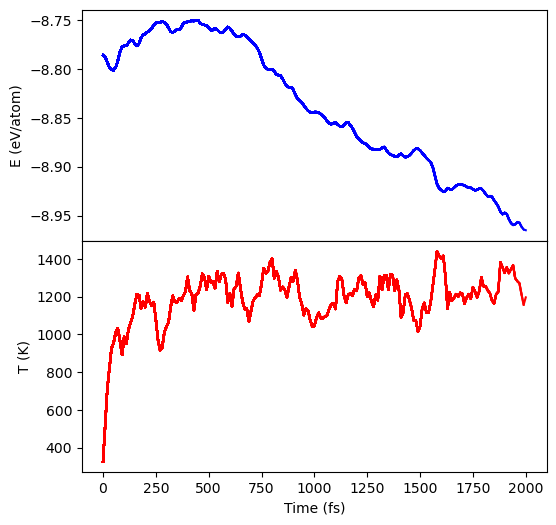

MD finished in 11.64 minutes!


In [15]:
#let us start with a single structure at random from the generated atoms lists
random_index = np.random.randint(0, len(generated_atoms_list))
init_conf = generated_atoms_list[random_index]

#we can use MACE as a calculator in ASE!
from mace.calculators import MACECalculator

model_paths = ['../models/zr-w-v-ti-cr/gen_0/models_out/vcrtiwzr_all_e1_f50_25s_seed_0_compiled.model',
               '../models/zr-w-v-ti-cr/gen_0/models_out/vcrtiwzr_all_e1_f50_25s_seed_1_compiled.model',
               '../models/zr-w-v-ti-cr/gen_0/models_out/vcrtiwzr_all_e1_f50_25s_seed_2_compiled.model',
               '../models/zr-w-v-ti-cr/gen_0/models_out/vcrtiwzr_all_e1_f50_25s_seed_3_compiled.model',
               '../models/zr-w-v-ti-cr/gen_0/models_out/vcrtiwzr_all_e1_f50_25s_seed_4_compiled.model']

#model_paths = ['../models/zr-w-v-ti-cr/gen_0/models_out/vcrtiwzr_all_e1_f50_25s_seed_0_compiled.model']
model_paths = ['../models/zr-w-v-ti-cr/vcrtiwzr_neb_e1_f50_s25_gen0_stagetwo_compiled.model']
mace_calc = MACECalculator(model_paths=model_paths, device='cpu', default_dtype='float32')

simpleMD(init_conf, temp=1200, calc=mace_calc, fname='vcrtiwzr_nnmd/gen_0_md.xyz', s=10, T=2000)

In [16]:
finished_atoms = read('./vcrtiwzr_nnmd/gen_0_md.xyz', index=':')
print(f"Number of frames: {len(finished_atoms)}")

for i, atoms in enumerate(finished_atoms):
    print(f"Frame {i+1} : {atoms.get_potential_energy()} eV")   


Number of frames: 201
Frame 1 : -1089.4864501953125 eV
Frame 2 : -1089.7086181640625 eV
Frame 3 : -1090.342041015625 eV
Frame 4 : -1091.0140380859375 eV
Frame 5 : -1091.3248291015625 eV
Frame 6 : -1091.3560791015625 eV
Frame 7 : -1090.990478515625 eV
Frame 8 : -1090.1678466796875 eV
Frame 9 : -1089.0401611328125 eV
Frame 10 : -1088.41455078125 eV
Frame 11 : -1088.2882080078125 eV
Frame 12 : -1088.2789306640625 eV
Frame 13 : -1087.91259765625 eV
Frame 14 : -1087.53759765625 eV
Frame 15 : -1087.57861328125 eV
Frame 16 : -1088.00830078125 eV
Frame 17 : -1088.2869873046875 eV
Frame 18 : -1087.9837646484375 eV
Frame 19 : -1087.2589111328125 eV
Frame 20 : -1086.8759765625 eV
Frame 21 : -1086.761474609375 eV
Frame 22 : -1086.520263671875 eV
Frame 23 : -1086.3291015625 eV
Frame 24 : -1086.0579833984375 eV
Frame 25 : -1085.657958984375 eV
Frame 26 : -1085.3701171875 eV
Frame 27 : -1085.3155517578125 eV
Frame 28 : -1085.29736328125 eV
Frame 29 : -1085.1829833984375 eV
Frame 30 : -1085.2907714843